In [1]:
% matplotlib notebook
import json
from utils import *

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener

import math
import scipy

from indicator_simulation import *

/Users/stranot/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# data_file = 'val_err_wo_lr_decay.json'
# data_file = 'val_err.json'
# data_file = 'jsons/bs_32_val_err.json'
# data_file = 'imagenet_dataset0.json'
data_file = 'jsons/cifar_all_lr_5e_2.json'
with open(data_file) as f:
    val_acc = json.load(f)

val_err = 1 - np.array(val_acc)
num_epochs_between_eval = 100
min_delta = 5e-4
patience = 13
# steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

smooth_win_size = 55
whole_smoothed_val_err = smooth_by_linear_filter(val_err, smooth_win_size)
plt.figure()
plt.plot((np.arange(len(val_err)) + 1)*num_epochs_between_eval, val_err)
plt.plot((np.arange(len(whole_smoothed_val_err)) + 1)*num_epochs_between_eval, whole_smoothed_val_err)

<IPython.core.display.Javascript object>

In [3]:
minEpoch = (np.argmin(whole_smoothed_val_err)+1)*num_epochs_between_eval
print(minEpoch, np.min(whole_smoothed_val_err), len(whole_smoothed_val_err))
earlyStoppingStep = early_stopping_step(val_err, min_delta, patience, smooth_win_size, num_epochs_between_eval )
print(earlyStoppingStep, whole_smoothed_val_err[earlyStoppingStep//num_epochs_between_eval+1])
# earlyStoppingStep = 9220

62300 0.18210545344786214 684
41400 0.19559272852810947


In [4]:
steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval
plt.figure()
whole_a, whole_b = power_regression(steps, val_err, np.ones(len(steps)))
err = val_err-whole_a*np.power(steps,whole_b)
ax = plt.subplot()
ax.plot(steps, val_err-whole_a*np.power(steps,whole_b))
ax.plot(steps, np.zeros(len(steps)))

plt.figure()
whole_a, whole_b = power_regression(steps, val_err, np.ones(len(steps)))
ax = plt.subplot()
ax.plot(steps[100:], err[100:])
err_a, err_b = np.linalg.lstsq(np.vstack([steps[100:], np.ones(len(steps[100:]))]).T, err[100:], rcond=None)[0]
ax.plot(steps[100:], err_a*steps[100:] + err_b)

res = err[100:] - err_a*steps[100:] - err_b

plt.figure()
_ = scipy.stats.probplot(res, dist=scipy.stats.rayleigh, plot=plt)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
plt.figure()
plt.plot(steps, val_err)

fun = lambda x: np.sum(np.power(val_err-(np.exp(x[1]*np.log(steps)+np.log(x[0]))+x[2]*(steps-x[3])),2))
bnds = ((0, None), (None, 0), (0, None),(0, None))
res = scipy.optimize.minimize(fun, (1,0,0,8000), method='TNC', bounds=bnds)

plt.plot(steps,(res.x[0]*np.power(steps, res.x[1])+res.x[2]*(steps-res.x[3])))


<IPython.core.display.Javascript object>

In [6]:
# """
# Predict the early stopping epoch by "adding-noise" method
# input: 
#     a, b: y = ax^b
#     var: the variance of unsmoothed data
#     min_delta, patience: no improvement (less than min_delta) for patience epoch is stopping criteria
#     smooth_win_size: the window size for smoothing
#     num_samples: how many samples to generate when using bootstrapping
#     upper_limit: only consider the predicted epoch smaller than upper_limit
#     lower_limit: only consider the predicted epoch larger than upper_limit
# return:
#     mean: mean of all predicted epochs
#     stopping_epochs: all predicted epochs
#     sample: one of the sythetic data
#     smoothed_sample: smoothing the sythetic data
# """
# def early_stopping_prediction_adding_noise(a,b,var,min_delta,patience, 
#                                            num_epochs_between_eval,
#                                            smooth_win_size,
#                                            num_samples=100,
#                                            upper_limit=2e4,
#                                         lower_limit=0
#                                           ):
#     num_points = int((upper_limit-lower_limit) // num_epochs_between_eval) # the number of noisy points we want to generate
# #     s = int(lower_limit //num_epochs_between_eval)
    
# #     x = np.arange(s,num_points+s)*num_epochs_between_eval
#     x = np.linspace(lower_limit, upper_limit, num_points) 
#     y = a*np.power(x,b)
        
#     stopping_epochs = [] 
#     for i in range(num_samples):
# #         noise = np.random.normal(0, np.sqrt(var), num_points)
#         noise = np.random.rayleigh(np.sqrt((4-np.pi)/2*var), num_points) - var*np.sqrt(np.pi/2)
#         z = y + noise
        
#         if i == 0:
#             sample = z
#             smoothed_sample = smooth_by_linear_filter(z, smooth_win_size)
        
#         try:
#             stopping_epochs.append(
#                 early_stopping_step(z, min_delta, patience, smooth_win_size, num_epochs_between_eval) + lower_limit)
#         except:
#             continue
    
#     return np.mean(stopping_epochs), np.array(stopping_epochs), sample, smoothed_sample

# def mean_confidence_interval(data, confidence=0.95):
#     a = 1.0 * np.array(data)
#     n = len(a)
#     m, se = np.mean(a), scipy.stats.sem(a)
#     h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
#     return m, m-h, m+h

In [7]:
# '''
# simulate early stopping prediction
# input:
#     data: the data that used to predict the epoch
#     smooth_win_size: window size for smoothing
#     epochs_between_eval: number of epochs between two evals
#     min_delta, patience: no improvement (less than min_delta) for patience epoch is stopping criteria
#     pred_win_size: the window size for epoch prediction, wrt points not real epochs
#     left_tail_size: the window where the data should be weighted (< 1) when doing regression, 
#                     wrt points not real epochs
#     period: the period for prediction, wrt points not real epochs
#     start_point: at which point we start the first prediction, wrt points not real epochs
#     weights_type: the type of weights
#                     linear: the weights are linear from 0-1 within the left_tail_size
#                     equal: the weights are 1 within the left_tail_size
#     num_samples: how many samples to generate when predicting the epoch by bootstrapping
#     upper_limit: only consider the predicted epoch smaller than upper_limit when doing bootstarpping
#     mode: mode = 0, then regression on the original data, mode = 1, then regression on the smoothed data
# output:
#     preds: predicted epochs
#     coeffs: regression coeffients (a,b)
#     shifts: the distance that we translation the piece curve to make it close to x-axis
#     sample: the sythetic data for each piece curve
#     smoothed_sample: smoothing the sythetic data
#     CIs: 95% confidence intervals    
# '''
# def sim_online_early_stopping_prediction_adding_noise(
#                                         data, 
#                                         smooth_win_size,
#                                          epochs_between_eval, 
#                                          min_delta, patience, 
#                                          pred_win_size, 
#                                          left_tail_size, 
#                                          period,
#                                          bounds, inits, method='TNC',
#                                          start_point=100, 
#                                          weights_type='linear',
#                                         num_samples=100,
#                                         upper_limit=2e4,
#                                         mode=0,
#                                         noise_est_win_size=None):
#     original_data = data
#     if mode == 0:
#         position_bias = 0
#     else:
#         position_bias = smooth_win_size - 1
#         data = smooth_by_linear_filter(data, smooth_win_size)
#     if noise_est_win_size == None:
#         noise_est_win_size = pred_win_size
        
#     ########################################
#     global_step = position_bias * epochs_between_eval
#     ########################################
    
#     # generate weights
#     w1_size = pred_win_size - left_tail_size # the number of elements we assign weight 1
#     if weights_type == 'linear':
#         basic_weights0 = np.linspace(0,1,left_tail_size)
#     elif weights_type == 'equal':
#         basic_weights0 = np.ones(left_tail_size)
#     basic_weights1 = np.ones(w1_size)
#     basic_weights = np.concatenate((basic_weights0, basic_weights1))
#     def weights_generator(length):
#         if length <= w1_size:
#             rst = np.ones(length)
#         elif length <= pred_win_size:
#             s = pred_win_size - length
#             rst = basic_weights[s:]
#         else:
#             z = np.zeros(length - pred_win_size)
#             rst = np.concatenate((z, basic_weights))

#         return rst
#     preds = []
#     coeffs = []
#     shifts = []
#     samples = []
#     smoothed_samples = []
#     CIs = []
#     vars_ = []
#     pred = 0
#         ########################################
#     for i in range(len(data)):
# #         print(i)
#         global_step += epochs_between_eval
    
#         ###############################
#         # save time, should be deleted in practice
#         if global_step > earlyStoppingStep:
#             break
#         ###############################
#         ########################################
#         num_evals = global_step//epochs_between_eval - position_bias

#         if num_evals >= start_point and (num_evals-start_point)%period == 0:
#             print(global_step)
            
#             # locate the smoothed points at the middle points of each window
#             if num_evals < pred_win_size:
#                 s = 0 + position_bias // 2
#             else:
#                 s = num_evals - pred_win_size + position_bias // 2
#             e = num_evals + position_bias // 2
            
#             if num_evals < noise_est_win_size:
#                 s_noise_est = 0
#             else:
#                 s_noise_est = num_evals - noise_est_win_size
            
#             # no shift
#             steps = (np.arange(s,e)+1) * epochs_between_eval
#             shift = steps[-1]
#             # shift the piece of curve 
# #             x = (np.arange(0,e-s)+1) * epochs_between_eval
# #             shift = s*epochs_between_eval
#             y = data[s - position_bias // 2:e - position_bias // 2]
#             weights = weights_generator(len(y))
            
#             a, b = power_regression(steps, y, weights)
# #             fun = lambda x: np.sum(np.power(y-(np.exp(x[1]*np.log(steps)+np.log(x[0]))), 2))
# #             res = scipy.optimize.minimize(fun, inits, method=method, bounds=bounds)
# #             a = res.x[0]
# #             b = res.x[1]

#             steps_noise_est = (np.arange(s_noise_est,e)+1) * epochs_between_eval
#             var = np.var(original_data[s_noise_est:e]-(a*np.power(steps_noise_est,b)))
            
# #             print(a,b,d,var,min_delta,patience,epochs_between_eval,smooth_win_size,num_samples,upper_limit)
            
#             last_pred = pred
#             pred, stopping_epochs, sample, smoothed_sample = early_stopping_prediction_adding_noise(
#                                                                 a,b,var,
#                                                                 min_delta,patience,
#                                                                  epochs_between_eval,
#                                                                  smooth_win_size,
#                                                                  num_samples=num_samples,
#                                                                  upper_limit=upper_limit,
#                                                                  lower_limit=steps[-1]
#                                                                                  )
#             print(pred, a,b)
            
#             _, CI_left, CI_right = mean_confidence_interval(stopping_epochs)
                
#             # we should do this because we shift the curve before
# #             pred += s*epochs_between_eval
#             preds.append(pred)
#             CIs.append((CI_left, CI_right))
#             coeffs.append((a,b))
#             shifts.append(shift)
#             samples.append(sample)
#             smoothed_samples.append(smoothed_sample)
            
            
#             vars_.append(var)
                        

#     return preds, coeffs, shifts, samples, smoothed_samples, CIs, vars_

# def CIs2errs(CIs):
#     errs = []
#     for ci in CIs:
#         errs.append((ci[1]-ci[0])/2)
    
#     return np.array(errs)


# pred_win_size = 1000
# left_tail_size = 0
# period = 20
# start_point = 10
# pred_min_delta = min_delta
# wtype = 'linear'
# num_samples = 1000
# bnds = ((0, None), (None, 0), (None, None))
# inits = (1,0,1)
# noise_est_win_size = 300

# # it's acually equivalent to setting no upper limit because 2e5 is larger enough
# upper_limit = 4e5

# # set a effective upper limit
# # upper_limit_bias = 80
# # upper_limit = (len(val_err) + upper_limit_bias)*num_epochs_between_eval
# preds_with_patience = []
# errs_with_patience = []

# patiences = range(13,14)
# for patience in patiences:
#     preds, coeffs, shifts, samples, smoothed_samples, CIs, _ = sim_online_early_stopping_prediction_adding_noise(
#                                         val_err,
# #                                         whole_smoothed_val_err,
#                                         smooth_win_size,
#                                          num_epochs_between_eval, 
#                                          pred_min_delta,
#                                          patience,
#                                         pred_win_size = pred_win_size,
#                                         left_tail_size = left_tail_size,
#                                         period = period,
#                                         bounds=bnds, inits=inits,
#                                         start_point = start_point,
#                                         weights_type = wtype,
#                                         num_samples=1000,
#                                         upper_limit=upper_limit,
#                                         mode=1,
#                                         noise_est_win_size = noise_est_win_size)
#     print(len(preds))

#     errs = CIs2errs(CIs)
    
#     preds_with_patience.append(preds)
#     errs_with_patience.append(errs)
    
# for patience in patiences:
#     preds, coeffs, shifts, samples, smoothed_samples, CIs, _ = sim_online_early_stopping_prediction_adding_noise(
#                                         val_err,
# #                                         whole_smoothed_val_err,
#                                         smooth_win_size,
#                                          num_epochs_between_eval, 
#                                          pred_min_delta,
#                                          patience,
#                                         pred_win_size = pred_win_size,
#                                         left_tail_size = left_tail_size,
#                                         period = period,
#                                         bounds=bnds, inits=inits,
#                                         start_point = start_point,
#                                         weights_type = wtype,
#                                         num_samples=1000,
#                                         upper_limit=upper_limit,
#                                         mode=0,
#                                         noise_est_win_size = noise_est_win_size)
#     print(len(preds))

#     errs = CIs2errs(CIs)
    
#     preds_with_patience.append(preds)
#     errs_with_patience.append(errs)

# for patience in patiences:
#     preds, coeffs, shifts, samples, smoothed_samples, CIs, _ = sim_online_early_stopping_prediction_adding_noise(
#                                         val_err,
# #                                         whole_smoothed_val_err,
#                                         smooth_win_size,
#                                          num_epochs_between_eval, 
#                                          pred_min_delta,
#                                          patience,
#                                         pred_win_size = pred_win_size,
#                                         left_tail_size = left_tail_size,
#                                         period = period,
#                                         bounds=bnds, inits=inits,
#                                         start_point = start_point,
#                                         weights_type = wtype,
#                                         num_samples=1000,
#                                         upper_limit=upper_limit,
#                                         mode=1)
#     print(len(preds))

#     errs = CIs2errs(CIs)
    
#     preds_with_patience.append(preds)
#     errs_with_patience.append(errs)
    
# for patience in patiences:
#     preds, coeffs, shifts, samples, smoothed_samples, CIs, _ = sim_online_early_stopping_prediction_adding_noise(
#                                         val_err,
# #                                         whole_smoothed_val_err,
#                                         smooth_win_size,
#                                          num_epochs_between_eval, 
#                                          pred_min_delta,
#                                          patience,
#                                         pred_win_size = pred_win_size,
#                                         left_tail_size = left_tail_size,
#                                         period = period,
#                                         bounds=bnds, inits=inits,
#                                         start_point = start_point,
#                                         weights_type = wtype,
#                                         num_samples=1000,
#                                         upper_limit=upper_limit,
#                                         mode=0)
#     print(len(preds))

#     errs = CIs2errs(CIs)
    
#     preds_with_patience.append(preds)
#     errs_with_patience.append(errs)


In [10]:
pred_win_size = 1000
left_tail_size = 0
period = 20
start_point = 10
pred_min_delta = min_delta
wtype = 'linear'
num_samples = 1000
bnds = ((0, None), (None, 0))
inits = (1,0)
noise_est_win_size = 300

# it's acually equivalent to setting no upper limit because 2e5 is larger enough
upper_limit = 4e5
preds_with_patience = []
errs_with_patience = []

# patiences = range(13,14)
# for patience in patiences:
# using smoothed data; estimate the noise by newest points
preds, coeffs, shifts, samples, smoothed_samples, CIs, _ = powerRegressionIndicator(
                                    earlyStoppingStep,
                                    val_err,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     pred_min_delta,
                                     patience,
                                    pred_win_size = pred_win_size,
                                    left_tail_size = left_tail_size,
                                    period = period,
                                    is_power_linear=False,
                                    bounds=bnds, inits=inits,
                                    start_point = start_point,
                                    weights_type = wtype,
                                    num_samples=1000,
                                    upper_limit=upper_limit,
                                    is_fit_smoothed=True,
                                    noise_est_win_size = noise_est_win_size)
print(len(preds))
errs = CIs2errs(CIs)
preds_with_patience.append(preds)
errs_with_patience.append(errs)

# using unsmoothed data; estimate the noise by newest points
preds, coeffs, shifts, samples, smoothed_samples, CIs, _ = powerRegressionIndicator(
                                    earlyStoppingStep,
                                    val_err,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     pred_min_delta,
                                     patience,
                                    pred_win_size = pred_win_size,
                                    left_tail_size = left_tail_size,
                                    period = period,
                                    is_power_linear=False,
                                    bounds=bnds, inits=inits,
                                    start_point = start_point,
                                    weights_type = wtype,
                                    num_samples=1000,
                                    upper_limit=upper_limit,
                                    is_fit_smoothed=False,
                                    noise_est_win_size = noise_est_win_size)
print(len(preds))
errs = CIs2errs(CIs)
preds_with_patience.append(preds)
errs_with_patience.append(errs)

# using smoothed data; estimate the noise by all points in the window
preds, coeffs, shifts, samples, smoothed_samples, CIs, _ = powerRegressionIndicator(
                                    earlyStoppingStep,
                                    val_err,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     pred_min_delta,
                                     patience,
                                    pred_win_size = pred_win_size,
                                    left_tail_size = left_tail_size,
                                    period = period,
                                    is_power_linear=False,
                                    bounds=bnds, inits=inits,
                                    start_point = start_point,
                                    weights_type = wtype,
                                    num_samples=1000,
                                    upper_limit=upper_limit,
                                    is_fit_smoothed=True,
                                    )
print(len(preds))
errs = CIs2errs(CIs)
preds_with_patience.append(preds)
errs_with_patience.append(errs)

# using unsmoothed data; estimate the noise by all points in the window
preds, coeffs, shifts, samples, smoothed_samples, CIs, _ = powerRegressionIndicator(
                                    earlyStoppingStep,
                                    val_err,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     pred_min_delta,
                                     patience,
                                    pred_win_size = pred_win_size,
                                    left_tail_size = left_tail_size,
                                    period = period,
                                    is_power_linear=False,
                                    bounds=bnds, inits=inits,
                                    start_point = start_point,
                                    weights_type = wtype,
                                    num_samples=1000,
                                    upper_limit=upper_limit,
                                    is_fit_smoothed=False,
                                    )
print(len(preds))
errs = CIs2errs(CIs)
preds_with_patience.append(preds)
errs_with_patience.append(errs)
    


6400
Predicted Stopping epoch is 180403.984063745. a = 11.182899408273824, b = -0.3945444779103546, d=0
8400
Predicted Stopping epoch is 152537.3024236038. a = 9.599328526899972, b = -0.37567348366715975, d=0
10400
Predicted Stopping epoch is 205604.26356589148. a = 69.31198590001455, b = -0.6151363371636499, d=0
12400
Predicted Stopping epoch is 209509.4861660079. a = 90.1270764586455, b = -0.6465737382222329, d=0
14400
Predicted Stopping epoch is 206809.12052117265. a = 74.18672395259016, b = -0.6236386389210639, d=0
16400
Predicted Stopping epoch is 214690.0552486188. a = 55.66643111468452, b = -0.5901341604029543, d=0
18400
Predicted Stopping epoch is 204981.5450643777. a = 40.62722665147416, b = -0.5537281851748785, d=0
20400
Predicted Stopping epoch is 188514.59016393442. a = 29.280152872939844, b = -0.5161673951219563, d=0
22400
Predicted Stopping epoch is 179059.36675461743. a = 21.93397693782975, b = -0.4832858380695497, d=0
24400
Predicted Stopping epoch is 159892.3408845739.

<IPython.core.display.Javascript object>


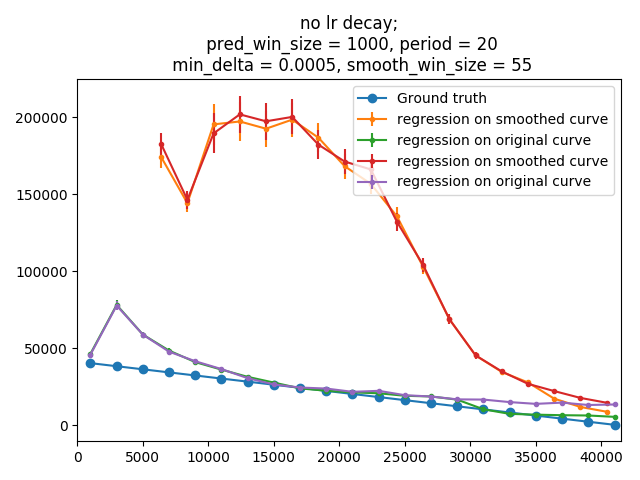

[ 6400  8400 10400 12400 14400 16400 18400 20400 22400 24400 26400 28400
 30400 32400 34400 36400 38400 40400]


In [11]:
fig = plt.figure()

x = (start_point+(np.arange(len(preds)))*period)*num_epochs_between_eval
x_smooth = (x+ (smooth_win_size-1) * num_epochs_between_eval)[:len(preds_with_patience[0])]
print(x_smooth)

plt.plot(x, earlyStoppingStep-x,'-o')

legend = ['Ground truth']
# for i, v in enumerate(patiences):
#     plt.errorbar(x, preds_with_patience[i]-x, errs_with_patience[i], fmt='.-')
#     legend.append('Indicator: patience = {}'.format(v))

for i in range(4): 
    if i == 0 or i == 2:
#         x_smooth = x + smooth_win_size * num_epochs_between_eval
        plt.errorbar(x_smooth, preds_with_patience[i]-x_smooth, errs_with_patience[i], fmt='.-')
#         plt.errorbar(x, preds_with_patience[i]-x, errs_with_patience[i], fmt='.-')
        legend.append('regression on smoothed curve')
    else:
        plt.errorbar(x, preds_with_patience[i]-x, errs_with_patience[i], fmt='.-')
        legend.append('regression on original curve')

plt.xlim(0,earlyStoppingStep+100)

plt.legend(legend)
plt.title('no lr decay;\n pred_win_size = {0}, period = {1}\n min_delta = {2}, smooth_win_size = {4}'.
          format(pred_win_size, period, min_delta, patience, smooth_win_size))
fig.tight_layout()



# plt.savefig('result_figs/numerical_opt/bs_128/min_delta_5e_4/change_patience.png')

In [ ]:
# print(coeffs)
fig = plt.figure(figsize=[10, 8])
# ax = plt.subplot()
# ax.set_ylim(0, 1.5)
# ax.plot(steps, val_err)

co = 0
step_size = 4
for i in range(0,len(coeffs),step_size):
#     co += 1
#     ax = plt.subplot(4,4, co)
#     ax.set_ylim(0, 1.5)
# #     ax.plot(steps, val_err)
#     ax.plot(steps[:len(whole_smoothed_val_err)], whole_smoothed_val_err)
#     x = np.arange(1,len(smoothed_samples[i])+1)*num_epochs_between_eval
# #     ax.plot(x,smoothed_samples[i])
#     ax.plot(x+shifts[i],smoothed_samples[i])
# #     ax.plot(steps+shifts[i], coeffs[i][0]*np.power(steps,coeffs[i][1]))
#     e = (start_point + i*period)*num_epochs_between_eval
#     s = max(0, ((start_point+i*period) - pred_win_size)*num_epochs_between_eval)
#     ax.set_title('Sampled epochs:\n [{}, {}]'.format(s,e))
#     ax.set_xlim(-500,80000)
    
    co += 1
    ax = plt.subplot(4,4, co)
    ax.set_ylim(0, 1.5)
    ax.plot(steps, val_err)
    ax.plot(steps[:len(whole_smoothed_val_err)], whole_smoothed_val_err)
    ax.plot(steps[:len(whole_smoothed_val_err)],power_function(steps[:len(whole_smoothed_val_err)], coeffs[i][0], coeffs[i][1]))
    x = np.arange(1,len(samples[i])+1)*num_epochs_between_eval
#     ax.plot(x,smoothed_samples[i])
    ax.plot(x+shifts[i],samples[i])
#     ax.plot(steps+shifts[i], coeffs[i][0]*np.power(steps,coeffs[i][1]))
    e = (start_point + i*period)*num_epochs_between_eval
    s = max(0, ((start_point+i*period) - pred_win_size)*num_epochs_between_eval)
    ax.set_title('Sampled epochs:\n [{}, {}]'.format(s,e))
    ax.set_xlim(-500,80000)
    
fig.tight_layout()   